In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx
import os
# !pip install h3
import h3
# !pip install h3pandas
import h3pandas
from shapely import wkt

# AGGREGATE POP DENSITY

Hex 8 from Kontur

In [2]:
# # read population file
# import gzip
# with gzip.open(os.path.join('data','kontur_population_GB_20220630.gpkg.gz'), 'rb') as f:
#   pop_uk = gpd.read_file(f, driver='GPKG') 

# # Load london boundary shapefile
# london = ox.geocode_to_gdf('Greater London, UK')
# london = london.to_crs(epsg=4326)

# # filter for London only
# pop_uk.to_crs(epsg=4326, inplace=True)
# pop_london = pop_uk[pop_uk.geometry.intersects(london.geometry[0])]
# pop_london.set_index('h3', inplace=True)

# pop_london.head()

In [3]:
# # export to file
# pop_london.to_file(os.path.join('data','cleaned','pop_london_h8.geojson'))

OA2HEX

In [4]:
## Load Population by OA (Census 2021)
# Load OA shapefile
oa = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','OA_2011_London_gen_MHW.shp'))
oa.to_crs(epsg=4326, inplace=True)

# Read population data for OA21
oa21_pop_london = pd.read_csv(os.path.join('data','raw','population','oa_2021_pop_london.csv'))
oa_21 = gpd.read_file(os.path.join('data','raw','population','oa11tooa21.geojson')) # OA11 -> OA21 conversion
oa['OA21CD'] = oa['OA11CD'].map(oa_21.set_index('OA11CD')['OA21CD'])

# merge population data with OA shapefile
oa_pop_london = oa21_pop_london.merge(oa[['OA21CD','geometry']], left_on='OA21CD', right_on='OA21CD')
oa_pop_london = gpd.GeoDataFrame(oa_pop_london, crs='EPSG:4326', geometry='geometry')

In [5]:
## function to convert OA population gdf to hexagons gdf
def pop_oa2hex(oa_pop, resolution=8):
    # convert OA to hexagons
    h = oa_pop.h3.polyfill(resolution=resolution)
    
    # populate hexagons with population, weighted by area divide the population by the number of hexagons
    # This is to ensure that the population is distributed evenly across the hexagons
    h3_list = []
    pop_list = []

    for i in range(len(h)):
        for h3 in h.h3_polyfill[i]:
            h3_list.append(h3)
            pop_round = round(h.population[i]/len(h.h3_polyfill[i]))
            pop_list.append(pop_round)

    h3_pop = pd.DataFrame({'h3': h3_list, 'population': pop_list})
    h3_pop.set_index('h3', inplace=True)

    # filter for invalid hexagons
    h3_pop = h3_pop.h3.h3_is_valid()
    h3_pop = h3_pop[h3_pop.h3_is_valid == True]
    h3_pop.drop(columns=['h3_is_valid'], inplace=True)

    # convert to geodataframe
    h3_pop_gdf = h3_pop.h3.h3_to_geo_boundary()

    return h3_pop_gdf   

In [6]:
pop_hex10 = pop_oa2hex(oa_pop_london, 10)
pop_hex10.to_crs(epsg=27700,inplace=True)
pop_hex10.reset_index(inplace=True)
pop_hex10.head()

,h3,population,geometry
0,8a194ad362c7fff,259,"POLYGON ((532210.421 181888.671, 532144.428 18..."
1,8a194ad32947fff,29,"POLYGON ((532103.202 181582.508, 532037.206 18..."
2,8a194ad30497fff,29,"POLYGON ((532193.966 181338.310, 532127.971 18..."
3,8a194ad32967fff,29,"POLYGON ((532179.503 181674.542, 532113.508 18..."
4,8a194ad32957fff,29,"POLYGON ((531981.517 181612.572, 531915.520 18..."


# AGGREGATE POI DENSITY BY TYPE

1. PLACES OF WORKSHIP

In [7]:
# Load Places of worship (area), take centroid
gdf_pofw = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_pofw_a_free_1.shp'))
gdf_pofw.to_crs(epsg=27700, inplace=True)
gdf_pofw['geometry'] = gdf_pofw.centroid

# Load Places of worship (point)
gdf_pofw_pt = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_pofw_free_1.shp'))
gdf_pofw_pt.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_pofw_merged = pd.concat([gdf_pofw, gdf_pofw_pt], ignore_index=True)
gdf_pofw_merged['category']='religious'
gdf_pofw_merged.tail()

,osm_id,code,fclass,name,geometry,category
3096,11479357650,3103,christian_evangelical,UCKG Help Centre,POINT (539092.764 184583.684),religious
3097,11543657111,3300,muslim,Chadwell Heath Muslim Centre,POINT (547336.060 187774.258),religious
3098,11544241893,3100,christian,West Wickham Methodist Church,POINT (538761.375 165985.736),religious
3099,11780635078,3300,muslim,Limehouse Bangladeshi Cultural Centre,POINT (536918.189 180871.930),religious
3100,11780635081,3300,muslim,None,POINT (536935.615 180861.505),religious


Text(0.5, 1.0, 'Places of Worship')

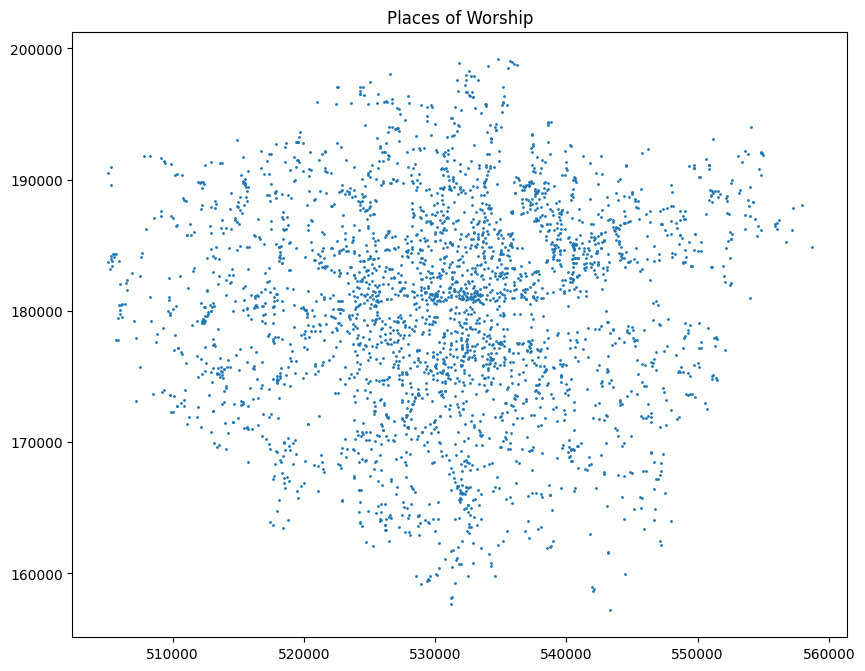

In [8]:
# Plot
gdf_pofw_merged.plot(markersize=1, figsize=(10,10),).set_title('Places of Worship')

2. NATURAL

In [9]:
# Load Points of interest (area), take centroid
gdf_natural = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_natural_a_free_1.shp'))
gdf_natural.to_crs(epsg=27700, inplace=True)

# Load Points of interest (point)
gdf_natural_pt = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_natural_free_1.shp'))
gdf_natural_pt.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_natural_merged = pd.concat([gdf_natural_pt, gdf_natural], ignore_index=True)
gdf_natural_merged = gdf_natural_merged[gdf_natural_merged.fclass!='tree'] # exclude trees
gdf_natural_merged['category']='nature'
gdf_natural_merged.tail()

,osm_id,code,fclass,name,geometry,category
170285,999893593,4141,beach,None,"POLYGON ((539096.561 178614.073, 539098.012 17...",nature
170286,1005610086,4141,beach,None,"POLYGON ((521214.847 186681.280, 521229.781 18...",nature
170287,1049504649,4141,beach,None,"POLYGON ((545770.001 170410.328, 545771.052 17...",nature
170288,1157972101,4141,beach,None,"POLYGON ((545648.455 181719.724, 545649.489 18...",nature
170289,1276244357,4141,beach,None,"POLYGON ((530638.876 194351.549, 530639.324 19...",nature


Text(0.5, 1.0, 'Natural POIs')

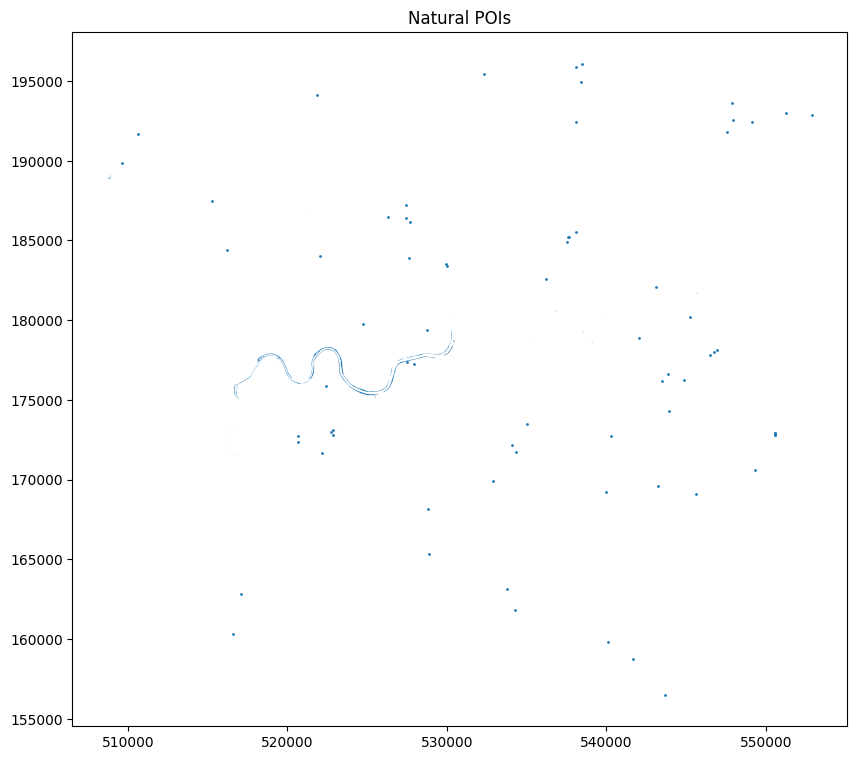

In [10]:
gdf_natural_merged.plot(markersize=1, figsize=(10,10),).set_title('Natural POIs')

3. WATER AND WATERWAYS

In [11]:
# Load Points of interest (area), take centroid
gdf_water= gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_water_a_free_1.shp'))
gdf_water.to_crs(epsg=27700, inplace=True)

# Load Points of interest (area), take centroid
gdf_waterw= gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_waterways_free_1.shp'))
gdf_waterw.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_water_merged = pd.concat([gdf_water, gdf_waterw], ignore_index=True)
gdf_water_merged['category']='nature'
gdf_water_merged.tail()

,osm_id,code,fclass,name,geometry,width,category
7734,1273953031,8101,river,River Colne,"LINESTRING (505059.081 184741.011, 505080.546 ...",0.0,nature
7735,1273953032,8101,river,River Colne,"LINESTRING (505045.151 184757.890, 505059.081 ...",0.0,nature
7736,1273953181,8101,river,River Colne,"LINESTRING (505080.546 184715.010, 505085.647 ...",0.0,nature
7737,1273953182,8101,river,River Colne,"LINESTRING (505027.369 184783.311, 505045.151 ...",0.0,nature
7738,1274645802,8102,stream,None,"LINESTRING (528024.932 200312.620, 528033.700 ...",0.0,nature


Text(0.5, 1.0, 'Water and Waterways')

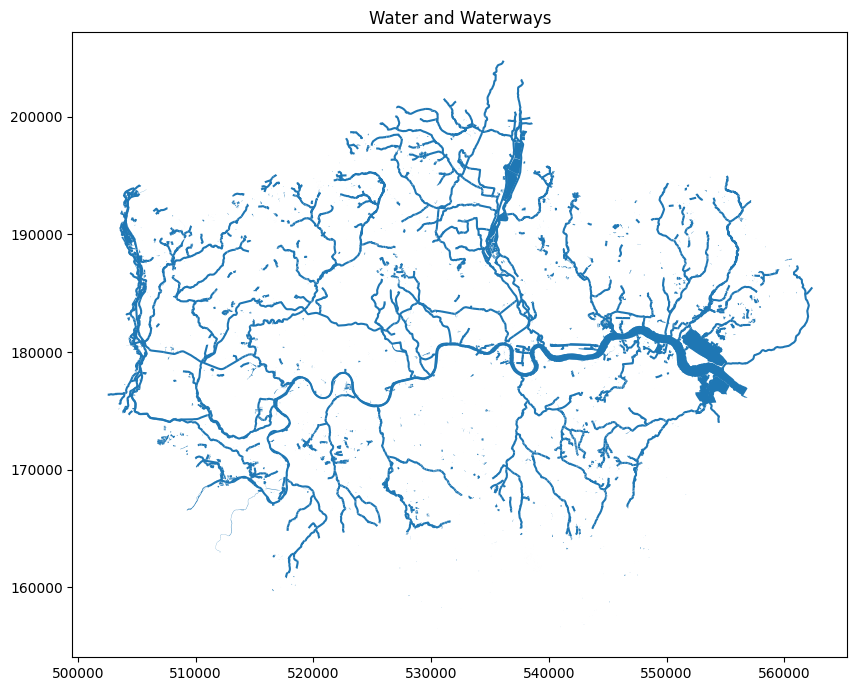

In [12]:
gdf_water_merged.plot(markersize=1, figsize=(10,10),).set_title('Water and Waterways')

4. POINT OF INTEREST

In [13]:
# Load Points of interest (area), take centroid
gdf_poi = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_pois_a_free_1.shp'))
gdf_poi.to_crs(epsg=27700, inplace=True)
# gdf_poi['geometry'] = gdf_poi.centroid

# Load Points of interest (point)
gdf_poi_pt = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_pois_free_1.shp'))
gdf_poi_pt.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_poi_merged = pd.concat([gdf_poi, gdf_poi_pt], ignore_index=True)
gdf_poi_merged.tail()

,osm_id,code,fclass,name,geometry
134864,11871881153,2561,hairdresser,"AB Barbers, Nails & Beauty",POINT (532435.230 177888.268)
134865,11871885714,2301,restaurant,We Are Mixed Blessings,POINT (532429.509 177860.099)
134866,11871901022,2561,hairdresser,Back To Eden,POINT (532419.012 177829.113)
134867,11871927672,2542,bicycle_shop,Community Bike Shop,POINT (531800.451 177392.099)
134868,11871927780,2561,hairdresser,Lugie’s Salon,POINT (532402.866 177793.318)


In [14]:
# add new column, extract first 2 digits of code column
gdf_poi_merged['category_code'] = gdf_poi_merged['code'].astype('string').str[:2]

# add new column, value depends on category column, 20 is restaurant, 25 is culture
poi_dict = {
    '20':'public_facilities',
    '21':'medical',
    '22':'leisure_active',
    '23':'restaurants',
    '24':'hotels',
    '25':'shopping',
    '26':'banking',
    '27':'tourism',
    '29':'miscellaneous'
    }

gdf_poi_merged['category'] = gdf_poi_merged['category_code'].map(poi_dict, na_action='ignore')
#drop category code
gdf_poi_merged.drop(columns=['category_code'], inplace=True)


In [15]:
# Change category columns for rows whose code is 2204 2205 2206 to leisure_outdoor
gdf_poi_merged.loc[gdf_poi_merged['code'].isin([2201,2202,2203]),'category'] = 'leisure_nightlife'
gdf_poi_merged.loc[gdf_poi_merged['code'].isin([2204,2205,2206]),'category'] = 'leisure_outdoor'
# remove rows misscellanous
gdf_poi_merged = gdf_poi_merged[gdf_poi_merged.category!='miscellaneous']

,osm_id,code,fclass,name,geometry,category
134864,11871881153,2561,hairdresser,"AB Barbers, Nails & Beauty",POINT (532435.230 177888.268),shopping
134865,11871885714,2301,restaurant,We Are Mixed Blessings,POINT (532429.509 177860.099),restaurants
134866,11871901022,2561,hairdresser,Back To Eden,POINT (532419.012 177829.113),shopping
134867,11871927672,2542,bicycle_shop,Community Bike Shop,POINT (531800.451 177392.099),shopping
134868,11871927780,2561,hairdresser,Lugie’s Salon,POINT (532402.866 177793.318),shopping


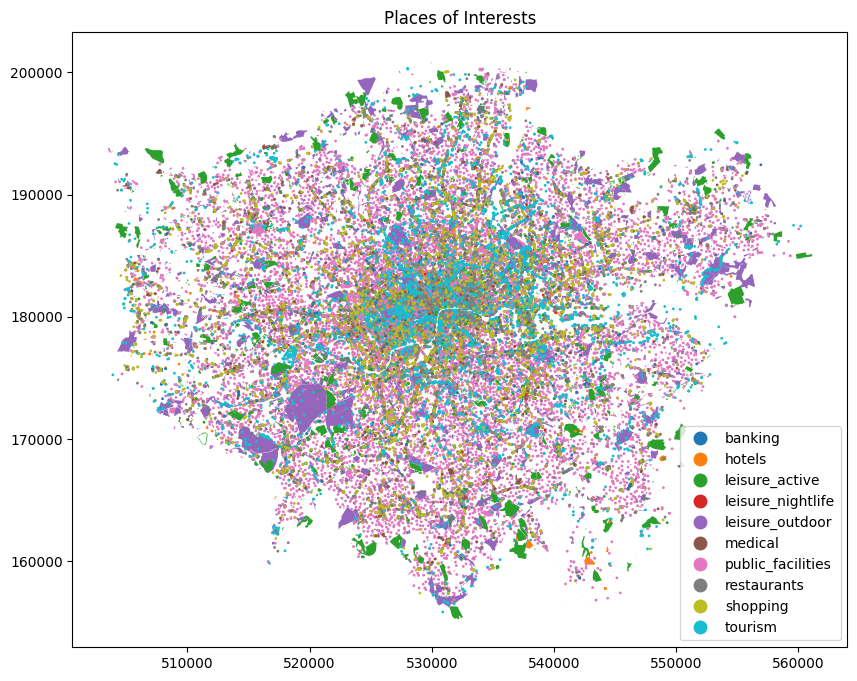

In [16]:
# Plot
gdf_poi_merged.plot(markersize=1, figsize=(10,10),column='category',legend=True).set_title('Places of Interests')
gdf_poi_merged.tail()

5. TRANSPORT

In [17]:
transport_list =['bus_station','airport','ferry_terminal']
transport_list_other = ['airfield','taxi','helipad']
transport_list_rail = ['railway_station']

In [18]:
# load transport
gdf_transport = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_transport_free_1.shp'))
gdf_transport.to_crs(epsg=27700, inplace=True)
gdf_transport1 = gdf_transport[gdf_transport.fclass.isin(transport_list)]
gdf_transport1['category']='transport_hub'
gdf_transport2 = gdf_transport[gdf_transport.fclass.isin(transport_list_other)]
gdf_transport2['category']='transport_other'
gdf_transport3 = gdf_transport[gdf_transport.fclass.isin(transport_list_rail)]
gdf_transport3['category']='transport_rail'

# load transport (area), take centroids
gdf_transport_a = gpd.read_file(os.path.join('data','raw','osm','greater-london-latest-free.shp','gis_osm_transport_a_free_1.shp'))
gdf_transport_a.to_crs(epsg=27700, inplace=True)
gdf_transport_a1 = gdf_transport_a[gdf_transport_a.fclass.isin(transport_list)]
gdf_transport_a1['category']='transport_hub'
gdf_transport_a2 = gdf_transport_a[gdf_transport_a.fclass.isin(transport_list_other)]
gdf_transport_a2['category']='transport_other'
gdf_transport_a3 = gdf_transport_a[gdf_transport_a.fclass.isin(transport_list_rail)]
gdf_transport_a3['category']='transport_rail'

# load
gdf_bus_stops = gpd.read_file('data/raw/tfl/Bus_Stops.geojson')
gdf_bus_stops.to_crs(epsg=27700, inplace=True)

gdf_bus_stops['osm_id'] = 0
gdf_bus_stops['code'] = gdf_bus_stops['STOP_CODE']
gdf_bus_stops['fclass'] = 'bus_stop'
gdf_bus_stops['name'] = gdf_bus_stops['STOP_NAME']
gdf_bus_stops['category'] = 'transport_busstops'
gdf_bus_stops = gdf_bus_stops[['osm_id','code','fclass','name','geometry','category']]

gdf_bus_stops.head()

# merge
gdf_transport_merged = pd.concat([gdf_transport1, 
                                  gdf_transport2,
                                  gdf_transport3,
                                  gdf_transport_a1,
                                  gdf_transport_a2,
                                  gdf_transport_a3,
                                  gdf_bus_stops
                                ])

C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,osm_id,code,fclass,name,geometry,category
39,25649631,5622,bus_station,None,POINT (535917.245 194424.828),transport_hub
45,26972027,5622,bus_station,Uxbridge bus station,POINT (505608.341 184188.736),transport_hub
65,64694457,5661,ferry_terminal,London Bridge City Pier,POINT (533025.345 180407.135),transport_hub
92,181325656,5661,ferry_terminal,Barking Riverside,POINT (547013.219 181740.268),transport_hub
95,207554833,5622,bus_station,Peckham Bus Station,POINT (534329.558 176731.421),transport_hub


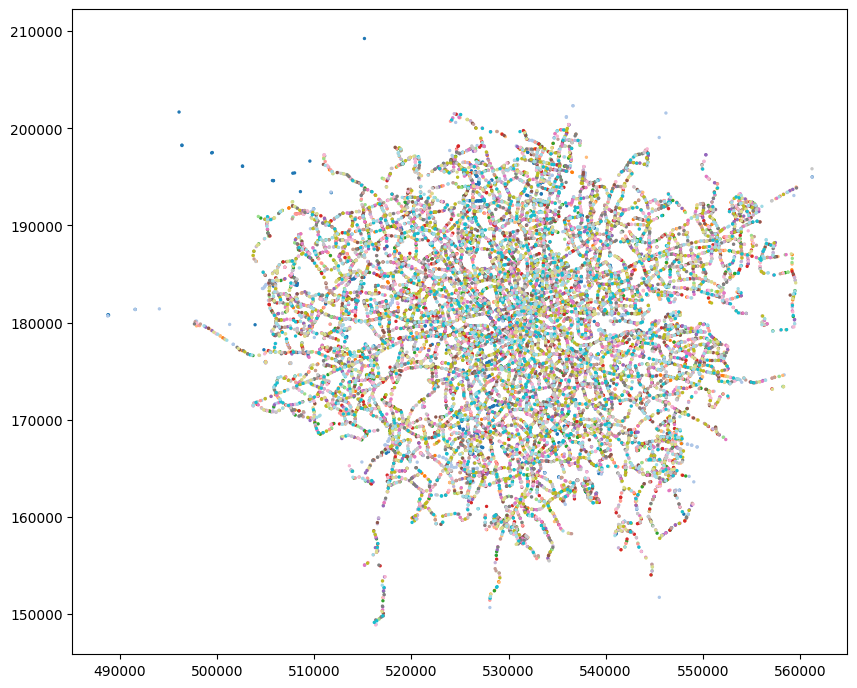

In [19]:
# plot and color by fclass
gdf_transport_merged.plot(markersize=2, figsize=(10,10),legend=True,cmap='tab20')
gdf_transport_merged.head()

MERGE EVERYTHING

Text(0.5, 1.0, 'All Points of Interest')

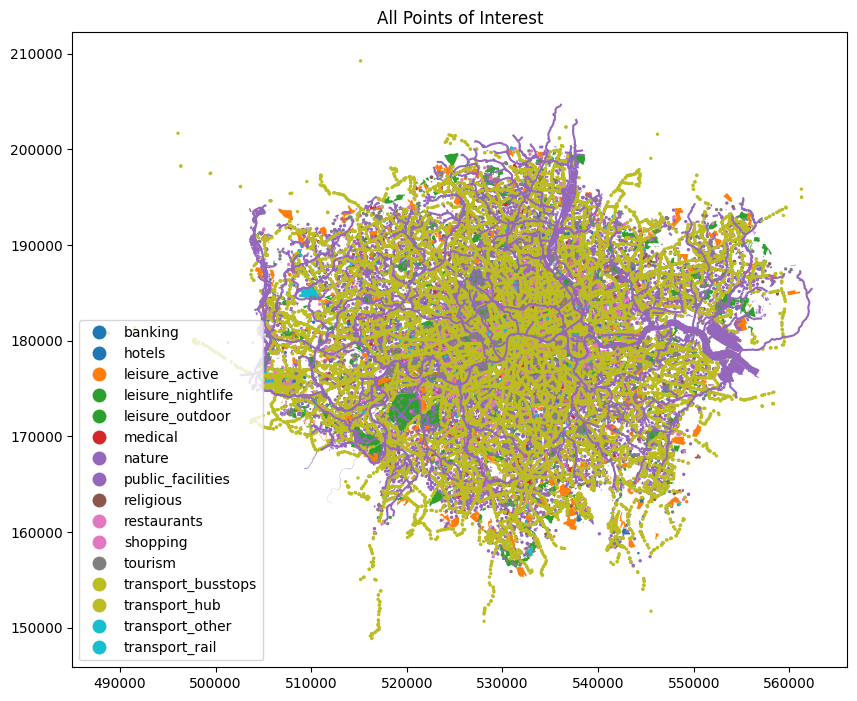

In [20]:
# Merge everything
gdf_poi_all = pd.concat([
    gdf_pofw_merged, 
    gdf_poi_merged, 
    gdf_transport_merged,
    gdf_natural_merged,
    gdf_water_merged
],ignore_index=True)
# plot
gdf_poi_all.plot(markersize=2, figsize=(10,10),column='category',legend=True).set_title('All Points of Interest')

In [21]:
gdf_poi_all.shape

(140256, 7)

#### AGGREGATE BY H3

In [22]:
# Create a geodataframe joining pop_london and gdf_poi_all, aggregate by h3
poi_h3 = gpd.sjoin(gdf_poi_all, pop_hex10, how='inner', predicate='intersects')

# aggregate by h3, count
poi_h3 = poi_h3.groupby(['h3','category']).size().reset_index(name='count')
poi_h3 = poi_h3.pivot(index='h3', columns='category', values='count').fillna(0).reset_index()

# merge with population
poi_pop_h3 = pop_hex10[['h3','geometry','population']].merge(poi_h3, on='h3', how='left').fillna(0)
poi_pop_h3 = gpd.GeoDataFrame(poi_pop_h3, geometry='geometry', crs='EPSG:27700')

poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   h3                  116586 non-null  object  
 1   geometry            116586 non-null  geometry
 2   population          116586 non-null  int64   
 3   banking             116586 non-null  float64 
 4   hotels              116586 non-null  float64 
 5   leisure_active      116586 non-null  float64 
 6   leisure_nightlife   116586 non-null  float64 
 7   leisure_outdoor     116586 non-null  float64 
 8   medical             116586 non-null  float64 
 9   nature              116586 non-null  float64 
 10  public_facilities   116586 non-null  float64 
 11  religious           116586 non-null  float64 
 12  restaurants         116586 non-null  float64 
 13  shopping            116586 non-null  float64 
 14  tourism             116586 non-null  float64 
 15  transport

In [31]:
# Add prefix poi_ to column 3-14 to distinguish it from transport pois

# Columns to rename
columns_to_rename = poi_pop_h3.columns[3:15]
# Prefix to add
prefix = 'poi_'

# # Loop through selected columns and rename
for col in columns_to_rename:
    poi_pop_h3.rename(columns={col: prefix + col}, inplace=True)


In [36]:
# loop through categories and plot

import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, 2, figsize=(10, 30))
for i, category in enumerate(poi_pop_h3.columns[3:]):
    ax = axs[i//2, i%2]
    poi_pop_h3.plot(column=category, ax=ax, legend=False, cmap='Oranges', scheme='NaturalBreaks', k=5)
    ax.set_title(category)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
poi_pop_h3.plot(column='Population', ax=ax, legend=False, cmap='Oranges', scheme='NaturalBreaks', k=5)
ax.set_title('Population')
ax.axis('off')
plt.tight_layout()
plt.show()

# EXPORT

In [35]:
#export to geojson
poi_pop_h3.to_file(os.path.join('data','cleaned','poi_pop_h3_r10.geojson'), driver='GeoJSON')